# LPC Statistics Course: Projects 
 > Fall 2017 Harrison B. Prosper and Ulrich Heintz

## Introduction
During Week 6 (week of October 23rd), you should work on at least one of the following statistical analysis projects.
  1. A binned fit to the CMS Run I $H \rightarrow \gamma \gamma$ data.
  2. <strike>An unbinned fit to the 580 __[Union 2.1 compilation](http://supernova.lbl.gov/union/)__ supernova distance modulus/red shift data.</strike>
  
You should write a __Python__ program to implement parameter estimation in the frequentist approach, with basically only one ground rule:

  * Use __TMinuit__ from ROOT for the minimization. We know many other minimizers exist, but we want you to learn how to use Minuit since it is the standard minimizer in particle physics.
   
Below we give some background for each project. 


## Higgs to $\gamma\gamma$ Project
 
Your task is to perform a __binned__ fit of a model of your choice to the CMS Run I $H \rightarrow \gamma\gamma$ data. The data (which can be downloaded from the LPC Statistics Course indico page) consists of event counts in $M = 100$ bins of width $0.8\,\textrm{GeV}$ from $100\,\textrm{GeV}$ to $180\,\textrm{GeV}$ in 
measured di-photon mass $m_{\gamma\gamma}$. The datasets are given as tables in two text files, one for the $7\,\textrm{TeV}$ data and the other for the $8\,\textrm{TeV}$ data. The first column in the tables are the mass bin centers $x_i$; the other columns contain observed event counts per mass bin for different categories of di-photon events. The $7\,\textrm{TeV}$ counts are split over 11 photon categories, while the $8\,\textrm{TeV}$ data have 14 categories.  However, for each bin, you should sum the event counts over all categories. If you are unable to get a reliable fit with the $7\,\textrm{TeV}$ data alone, add the summed $7\,\textrm{TeV}$ counts to those of the $8\,\textrm{TeV}$ dataset.

### Likelihood Function 
Assume the following probability function 
$$p(n \,|\,\theta) = \prod_{i=1}^{M} \textrm{Poisson}(n_i, a_i(\theta)),$$
where $a_i(\theta)$ is the mean count in bin $i$ and $\theta$ are the parameters of your model. Presumably, the parameters include those that describe the shape of your background as a function of di-photon mass as well as the parameters that describe the Higgs boson signal. The latter should include the Higgs boson mass $m_H$, the Higgs boson mean signal count $s$, and some measure $w$ of the width of the resonance. You may assume that the background is a monotically decreasing function of $m_{\gamma\gamma}$. We suggest that you start with the simplest possible model for the Higgs boson resonance, for example, a Gaussian. For the mean count $a_i$, assume a model of the form
\begin{align*}
a_i & = \int_\textrm{bin $i$} [s \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] \, dx_i,\\
    & \approx [s \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] \Delta x,
\end{align*}
where the integration is over the $i\textrm{th}$ mass bin, $x_i$ is the bin center, $\theta_s$ and $\theta_b$ are the parameters of your signal and background models, respectively, $\Delta x = 0.8\,\textrm{GeV}$ is the bin width, $f_s$ is the normalized Higgs boson resonance shape you have chosen (e.g., a Gaussian), and $f_b$ is your background shape, which need not be normalized unless of course you are interested in estimating the mean background count.

By definition, the likelihood is the probability function $p(n\,|\,\theta)$ into which the actual observations, here the counts $\{ D_i \}$, have been entered. In order to find the maximum likelihood estimates of the parameters (or as we more commonly say, fit the model to the data) you need to supply the negative log-likelihood function, 
$$nll(\theta) = \Delta x \sum_{i=0}^M [s \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)]   - \sum_{i=0}^M D_i \, \log[s \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] ,$$
 to __TMinuit__. In $nll(\theta)$ we have dropped terms that do not depend on the parameters.
 
 
### Project Tasks
  1. Use TMinuit to find the maximum likelihood estimates (and associated uncertainties) of the Higgs boson mass and signal. Superimpose the results of your fit on a histogram of the data.
  
  2. For each of the $M$ bins, compute the p-value. Since the p-value is computed bin-by-bin, it is referred to as *local p-value*. Recall that the p-value is the probability $\textrm{Pr}(X \geq D_i|H_0)$, under the null hypothesis $H_0$, of an observation equal to or more extreme than the actual observation. If the p-value is very small we must decide between two possibilities: either the null hypothesis is true and a rare fluctuation has occurred or the null hypothesis is false. If the p-value is small enough, we may be inclined to assume that  $H_0$ is false. 
  
  
An approximate p-value
$$\textrm{p-value} = \sum_{r=D_i}^\infty \textrm{Poisson}(r, a_i)$$ can be
computed using ROOT.TMath.Gamma($D_i$, $a_i$). The null hypothesis $H_0$ in this context is the background only hypothesis; therefore,
 use $a_i = f_b(x_i, \hat{\theta}_b) \, \Delta x$, where $\hat{\theta}_b$ are the estimated background parameters. Plot, using a log-y scale, the p-value as a function of the bin center. The p-value is approximate because we are not accounting for the fact that the background in each bin is not the true mean background, but rather an estimate of it.
  

---

### First let's checkout the data

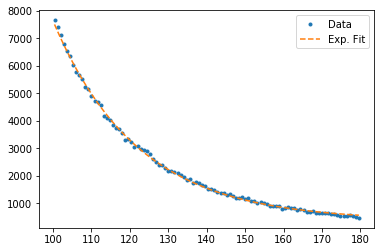

[  6.87191216e+05   4.55127657e-02   3.76399064e+02]


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
input7 = np.loadtxt('hgg_7TeV.txt', skiprows=1)
input8 = np.loadtxt('hgg_8TeV.txt', skiprows=1)
# Sum the event counts of all categories for each bin:
counts = np.zeros(shape=(input7.shape[0],2))
counts[:,0] = input7[:,0]
counts[:,1] = np.sum(input7[:,1:],axis=1) + np.sum(input8[:,1:],axis=1)

bc = counts[:,0] # bin center
D = counts[:,1] # data

# I want to get a feeling of the background shape by perfoming an exponential fit 
def expfit(x, a, b, c):
    return a * np.exp(-b * x) + c
popt, pcov = curve_fit(expfit, bc, D, p0 = (1, 1e-10, 1))
yy = expfit(bc, *popt)
plt.plot(bc,D,'.', label='Data')
plt.plot(bc,yy,'--', label='Exp. Fit')
plt.legend(loc='best')
plt.show()
print popt
#print pcov

---
The negative log-likelihood function:
$$nll(\theta) = \Delta x \sum_{i=0}^M [s \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)]   - \sum_{i=0}^M D_i \, \log[s \, f_s(x_i, \theta_s) + f_b(x_i, \theta_b)] ,$$
where
$f_s(x_i, \theta_s)$ is the normalized Gaussian of the Higgs resonance shape (centered at $x_i$, width $\sigma_H$), $f_b(x_i, \theta_b)$ is the background shape with exponential distribution

### Define the parameters of the nll

Parameter xval: <br>
xval[0] = mH (mass of the Higgs)<br>
xval[1] = s (mean signal count)<br>
xval[2] = w (width of the resonance). We have $f_s = \frac{s}{\sqrt{\pi*w^2/2}} * e^{-\frac{(x-m_H)^2}{w^2/2}}$ as $w = 2\sigma$<br>
xval[3] = c (background coefficient in $f_b = c*e^{-\lambda*x} + d$)<br>
xval[4] = $\lambda$ <br>
xval[5] = d <br>

### Implement the NNL

In [2]:
# Get parameters
deltax = 0.8

import os, sys
import ROOT as rt

def fs(x, s, mH, w):
    return s/np.sqrt(np.pi*(w**2)/2) * np.exp(-(x-mH)**2/((w**2)/2)) 

def fb(x, c, ld, d):
    return c*np.exp(-ld*x) + d

def sb(xval, i):
    return fs(x=bc[i], s=xval[1], mH=xval[0], w=xval[2]) + fb(x=bc[i], c=xval[3], ld = xval[4], d = xval[5])

def nnl(npar, grad, fval, xval, flag):
    first = 0
    second = 0
    for i in xrange(len(D)):
        first += deltax * sb(xval, i)
        second += D[i] * np.log(sb(xval, i))
    fval[0] = first - second

Welcome to JupyROOT 6.10/08


### Setup Minuit

In [3]:
def setupMinuit(params):
    print 'Setup Minuit...'
    PRINT_LEVEL = 1  # -1 => quiet, 1 => loud
    UP = 0.5 # 1: appropriate for 68% CL using chisq (use 0.5 for log-likelihood)
    npar = len(params)
    minuit = rt.TMinuit(npar)
    minuit.SetFCN(nnl)
    minuit.SetErrorDef(UP)
    minuit.SetPrintLevel(PRINT_LEVEL)

    status = rt.Long() # needed for integers passed by refence (int& ii)
    print "%-20s %10s %10s %10s %10s" % \
    ('param', 'guess', 'step', 'min', 'max')
    
    for ii, t in enumerate(params):
        print "%-20s %10.2e %10.3e %10.3e %10.3e" % t
        name, guess, step, pmin, pmax = t
        minuit.mnparm(ii, name, guess, step, pmin, pmax, status)
        if status != 0:
            sys.exit("** mnparm(%s) status = %d" % (name, status))
    return minuit

### Initialize parameters

In [31]:
#          name                    guess   step   min    max
params = [('Higgs mass',            125.,  1e-3,  100, 200.0),
          ('Mean signal count',      700.,  1e-4,    0.,  1.e3),
          ('Resonance width',        2.4,  1.e-3,    0,  10),
          ('Background coeffient', 6.87e5,  1.e-1,  1.e5,  1.e6),
          ('Background lambda',   4.55e-2,  1.e-4,  1.e-3, 1.e0),
          ('Background bias',      3.76e2,  1.e-3,   1.e2, 1.e3)]

minuit = setupMinuit(params)

Setup Minuit...
param                     guess       step        min        max
Higgs mass             1.25e+02  1.000e-03  1.000e+02  2.000e+02
Mean signal count      7.00e+02  1.000e-04  0.000e+00  1.000e+03
Resonance width        2.40e+00  1.000e-03  0.000e+00  1.000e+01
Background coeffient   6.87e+05  1.000e-01  1.000e+05  1.000e+06
Background lambda      4.55e-02  1.000e-04  1.000e-03  1.000e+00
Background bias        3.76e+02  1.000e-03  1.000e+02  1.000e+03
 **********
 **    1 **SET ERRDEF         0.5
 **********
 **********
 **    2 **SET PRINT           1
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 Higgs mass   1.25000e+02  1.00000e-03    1.00000e+02  2.00000e+02
     2 Mean signal count   7.00000e+02  1.00000e-04    0.00000e+00  1.00000e+03
     3 Resonance width   2.40000e+00  1.00000e-03    0.00000e+00  1.00000e+01
     4 Background coeffient   6.87000e+05  1.00000e-01    1.00000e+05  1.00000e+06
     5 Background la

### Perform fit

Running Minuit
Real time:      0.041 s

                name	      value	uncertainty
          Higgs mass	    124.444	      0.392
   Mean signal count	    306.670	    122.194
     Resonance width	      1.615	      0.474
Background coeffient	 757758.286	   2246.511
   Background lambda	      0.044	      0.000
     Background bias	    416.246	      6.332


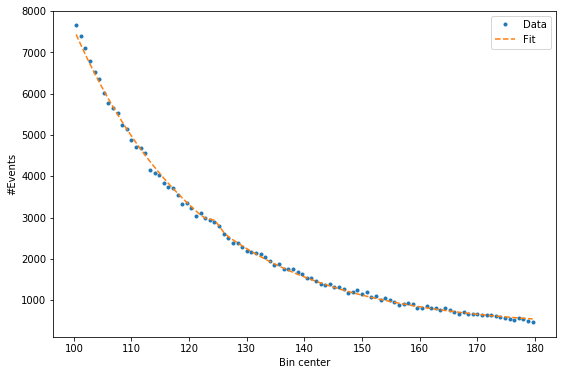

 **********
 **   10 **MIGRAD       1e+04      0.0001
 **********
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-07
 FCN=-1.68089e+06 FROM MIGRAD    STATUS=INITIATE       12 CALLS         374 TOTAL
                     EDM=0.00261108    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   6.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Higgs mass   1.24444e+02   3.91867e-01  -0.00000e+00   1.40369e+00
   2  Mean signal count   3.06670e+02   1.22194e+02   0.00000e+00  -6.08461e-03
   3  Resonance width   1.61515e+00   4.74347e-01   0.00000e+00  -2.91157e-02
   4  Background coeffient   7.57758e+05   2.24651e+03  -0.00000e+00   7.19861e+00
   5  Background lambda   4.42958e-02   2.29197e-05  -0.00000e+00   3.53096e+02
   6  Background bias   4.16246e+02   6.33245e+00  -0.00000e+00  -4.25604e-01
                               ERR DEF= 0.5
 MIGRAD FAILS TO FIND 

In [46]:
def performFit(minuit, params):
    from array import array
    
    LINE   = "="*80
    print LINE
    print "Running Minuit"
   
    # define fit control parameters
    MAXITER   = 10000
    TOLERANCE = 1e-4
    args = array('d')
    args.append(MAXITER)
    args.append(TOLERANCE)
    
    swatch = rt.TStopwatch()
    swatch.Start()
    
    # run MIGRAD minimizer
    status = rt.Long()
    minuit.mnexcm("MIGRAD", args, 2, status) # Don't know why but calling this multiple times seems to fix the problem of exit code 4
    if status != 0: sys.exit("** mnexcm status = %d" % status)
    print "Real time: %10.3f s" % swatch.RealTime()

    # print results
    print
    value = rt.Double() # needed for passing doubles by reference
    error = rt.Double()
    results = []
    print "%20s\t%11s\t%11s" % ('name', 'value', 'uncertainty')
    for ii, t in enumerate(params):
        name = t[0]
        minuit.GetParameter(ii, value, error)
        record = "%20s\t%11.3f\t%11.3f" % (name, value, error)
        print record
        results.append((float(value), float(error)))
    print LINE
    return results

results = performFit(minuit, params)

mH = results[0][0]
s = results[1][0]
w = results[2][0]
c = results[3][0]
ld = results[4][0]
d = results[5][0]

def fit_shape(x, mH, s, w, c, ld, d):
    return fs(x, s, mH, w) + deltax*fb(x, c, ld, d)

yfit = fit_shape(bc, mH, s, w, c, ld, d)
yinit = fit_shape(bc, mHi, si, wi, ci, ldi, di)
plt.figure(figsize=(9,6))
plt.plot(bc,D,'.', label='Data')
plt.plot(bc,yfit,'--', label='Fit')
plt.legend(loc='best')
plt.xlabel('Bin center')
plt.ylabel('#Events')
plt.show()

### Calculate the p-value

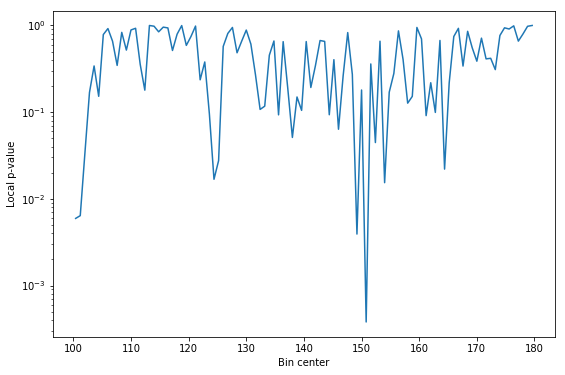

In [48]:
a = deltax * fb(bc, c, ld, d)
p = []
for i in xrange(len(a)):
    p.append(rt.TMath.Gamma(D[i],a[i]))
plt.figure(figsize=(9,6))
plt.plot(bc,p)
plt.yscale('log')
plt.xlabel('Bin center')
plt.ylabel('Local p-value')
plt.show()